In [1]:
import os

os.chdir("../")

In [2]:
import torch
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from kernel.GEMM import matmul

100%|██████████| 100/100 [00:01<00:00, 56.38it/s]


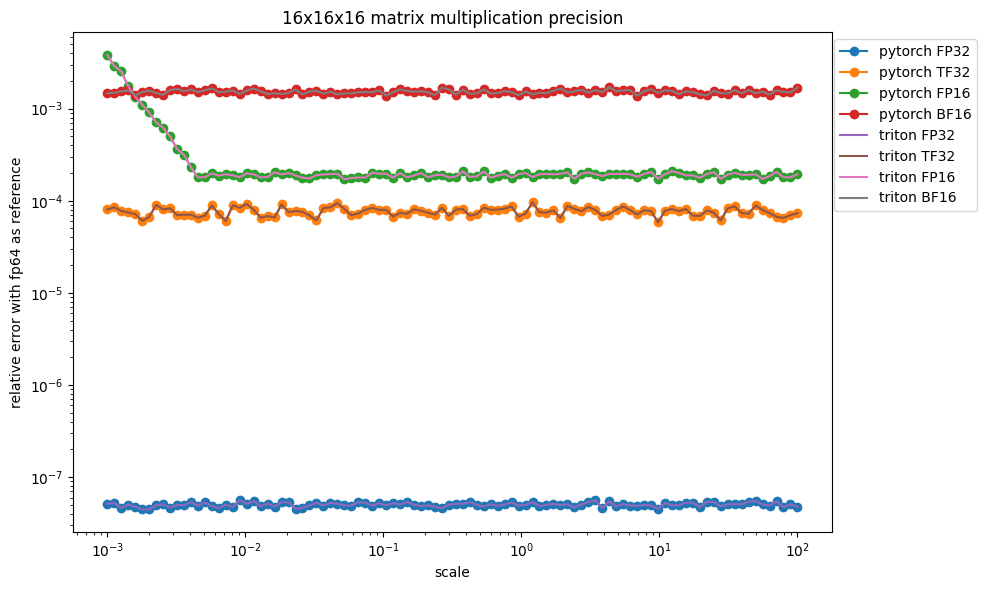

In [4]:
torch.manual_seed(0)

minscale = 0.001
maxscale = 100

nscales = 100
scales = np.logspace(np.log10(minscale), np.log10(maxscale), nscales)

err_ref_fp32 = np.zeros_like(scales, dtype=np.float32)
err_ref_tf32 = np.zeros_like(scales)
err_ref_fp16 = np.zeros_like(scales)
err_ref_bf16 = np.zeros_like(scales)
err_triton_fp32 = np.zeros_like(scales)
err_triton_tf32 = np.zeros_like(scales)
err_triton_fp16 = np.zeros_like(scales)
err_triton_bf16 = np.zeros_like(scales)

for i in tqdm(range(nscales)):

    scale = scales[i]

    N = 16
    A = torch.rand(N, N, dtype=torch.float64).cuda() * scale
    B = torch.rand(N, N, dtype=torch.float64).cuda() * scale

    C_ref_fp64 = A @ B # the golden reference

    torch.backends.cuda.matmul.allow_tf32 = False
    C_ref_fp32 = A.to(torch.float32) @ B.to(torch.float32)

    torch.backends.cuda.matmul.allow_tf32 = True
    C_ref_tf32 = A.to(torch.float32) @ B.to(torch.float32)

    C_ref_fp16 = A.to(torch.float16) @ B.to(torch.float16)
    C_ref_bf16 = A.to(torch.bfloat16) @ B.to(torch.bfloat16)

    C_triton_fp32 = matmul(A.to(torch.float32), B.to(torch.float32), tf32=False, precision_match=True)
    C_triton_tf32 = matmul(A.to(torch.float32), B.to(torch.float32), tf32=True, precision_match=True)
    C_triton_fp16 = matmul(A.to(torch.float16), B.to(torch.float16), tf32=False, precision_match=True)
    C_triton_bf16 = matmul(A.to(torch.bfloat16), B.to(torch.bfloat16), tf32=False, precision_match=True)

    def relative_error(x, y):
        return torch.abs(x - y).mean() / torch.abs(x).mean()

    err_ref_fp32[i] = relative_error(C_ref_fp64, C_ref_fp32)
    err_ref_tf32[i] = relative_error(C_ref_fp64, C_ref_tf32)
    err_ref_fp16[i] = relative_error(C_ref_fp64, C_ref_fp16)
    err_ref_bf16[i] = relative_error(C_ref_fp64, C_ref_bf16)

    err_triton_fp32[i] = relative_error(C_ref_fp64, C_triton_fp32)
    err_triton_tf32[i] = relative_error(C_ref_fp64, C_triton_tf32)
    err_triton_fp16[i] = relative_error(C_ref_fp64, C_triton_fp16)
    err_triton_bf16[i] = relative_error(C_ref_fp64, C_triton_bf16)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(scales, err_ref_fp32, label="pytorch FP32", marker="o")
ax.plot(scales, err_ref_tf32, label="pytorch TF32", marker="o")
ax.plot(scales, err_ref_fp16, label="pytorch FP16", marker="o")
ax.plot(scales, err_ref_bf16, label="pytorch BF16", marker="o")
ax.plot(scales, err_triton_fp32, label="triton FP32")
ax.plot(scales, err_triton_tf32, label="triton TF32")
ax.plot(scales, err_triton_fp16, label="triton FP16")
ax.plot(scales, err_triton_bf16, label="triton BF16")
ax.set_xlabel("scale")
ax.set_ylabel("relative error with fp64 as reference")
ax.set_title("16x16x16 matrix multiplication precision")

ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
plt.tight_layout()